In [4]:
import math
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import lea
import ipywidgets
from fractions import Fraction
from enum import Enum

# Elementary Hypothesis Testing

How do we measure our confidence in a hypothesis underlying our observed data?

Jaynes introduces this concept with binary (true or false) hypotheses about quality assurance in a widget factory (p. 93).
The example goes, suppose we have eleven machines each producing "widgets" --- that is, a product that we can test for good or bad craftsmanship. We suppose ten out of the eleven machines are good manufacturers: for every **six** widgets they create, only one is defective. The eleventh machine is a bad manufacturer, and for every **three** widgets it creates, one is defective.

![title](./factory_widgets.png)

Each machine produces its widgets into an exclusive, unlabelled box. Now suppose we are given one of these unlabelled boxes. We do not know what machine it came from, so we start testing the containing widgets one by one for good craftsmanship. What is our confidence that our box came from one of the ten good machines versus the eleventh bad machine?

Jaynes introduces the concept of "evidence" for a particular hypothesis using the log-likelihood of our data. As written in equation (4.13) on p.92, we define

\begin{equation} e(H|DX) = e(H|X) + 10 \sum_i log_{10} \left[ \frac{P(D_i|HX)}{P(D_i| \overline H X)} \right] \end{equation}

To this end, we have the following probability assignments:

In [150]:
A_prior = ipywidgets.FloatSlider(value=Fraction(1/11), min=0, max=1, step=Fraction(1/11), description="P(A|X)")
B_prior = ipywidgets.FloatSlider(value=Fraction(10/11), min=0, max=1, step=Fraction(1/11), description="P(B|X)")

A_sample_prob = ipywidgets.BoundedFloatText(value=Fraction(2/3), min=0, max=1, step=Fraction(1/6), description="P(D|AX)")
B_sample_prob = ipywidgets.BoundedFloatText(value=Fraction(5/6), min=0, max=1, step=Fraction(1/6), description="P(D|AX)")

display(A_prior)
display(B_prior)

display(A_sample_prob)
display(B_sample_prob)

FloatSlider(value=0.09090909090909091, description='P(A|X)', max=1.0, step=0.09090909090909091)

FloatSlider(value=0.9090909090909091, description='P(B|X)', max=1.0, step=0.09090909090909091)

BoundedFloatText(value=0.6666666666666666, description='P(D|AX)', max=1.0, step=0.16666666666666666)

BoundedFloatText(value=0.8333333333333334, description='P(D|AX)', max=1.0, step=0.16666666666666666)

i.e. \begin{equation} P(A|X) = 1/11 \ \ \ \ P(D|AX) = 2/3 \end{equation}
and \begin{equation} P(B|X) = 10/11 \ \ \ \ P(D|BX) = 5/6 \end{equation}

With [lea](https://bitbucket.org/piedenis/lea/), a python library for intuitive probabilistic programming, we write

As written in equation (4.39) on page 101,

\begin{equation} P(D | \overline C X) = \frac{P(D|AX)P(A|X) + P(D|BX)P(B|X)}{P(A|X) + P(B|X)} \end{equation} 

which is calculated for us by lea automatically with `D.given(C != 1)`

In [135]:
hypothesis = lea.pmf({'A': 1/11, 'B': 10/11})
widget = hypothesis.switch({
    'A': lea.bernoulli(2/3),
    'B': lea.bernoulli(5/6)
})

\begin{equation} P(D|AX) = {N \choose n} (1/3)^n (2/3)^{N-n} \end{equation}
\begin{equation} P(D|BX) = {N \choose n} (1/6)^n (5/6)^{N-n} \end{equation}

In [136]:
def evidence(X, x):
    return 10 * (math.log(lea.P(X == x), 10) - math.log(lea.P(X != x), 10))

def widget_likelihood(h, data):
    N = data.size
    n = data[data == 1].size
    ratio = lea.P(widget.given(hypothesis == h).times(N) == n) / lea.P(widget.given(hypothesis != h).times(N) == n)
    return 10 * math.log(ratio, 10)

def evidence_posterior(h, data):
    return evidence(hypothesis, h) + widget_likelihood(h, data)

In [133]:
evidence_posterior('A', np.array([0, 0, 0]))

-0.9691001300805571

In [134]:
def binomial(x, n, p):
    coefficient = math.factorial(n) / (math.factorial(x) * math.factorial(n - x))
    return coefficient * pow(p, x) * (1 - p, n - x)

def ev_a(data):
    N = data.size
    num_bad = data[data == 0].size
    num_good = data[data == 1].size
    p_prior = 1/11
    ev_prior = 10 * math.log(p_prior / (1 - p_prior), 10)
    ev_posterior = 10 * (math.log(pow(2/3, num_good) / pow(5/6, num_good), 10) + math.log(pow(1/3, num_bad) / pow(1/6, num_bad), 10))
    return ev_prior + ev_posterior
    
def ev_b(data):
    N = data.size
    num_bad = data[data == 0].size
    num_good = data[data == 1].size
    p_prior = 10/11
    ev_prior = 10 * math.log(p_prior / (1 - p_prior), 10)
    ev_posterior = 10 * (math.log(pow(5/6, num_good) / pow(2/3, num_good), 10) + math.log(pow(1/6, num_bad) / pow(1/3, num_bad), 10))
    return ev_prior + ev_posterior

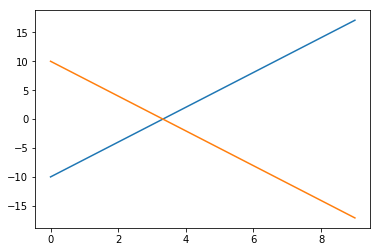

In [25]:
data = np.array([0] * 10)
evidence = np.array([ev_a(data[:i]) for i in range(data.size)])
plt.plot(range(data.size), evidence)

evidence = np.array([ev_b(data[:i]) for i in range(data.size)])
plt.plot(range(data.size), evidence)

In [151]:
data_size = 10
heatmap = []
for num_good in range(data_size):
    lst = []
    for num_bad in range(data_size):
        data = np.array([0] * num_bad + [1] * num_good)
        heat = ev_b(data) - ev_a(data)
        lst.append(heat)
    heatmap.append(lst)

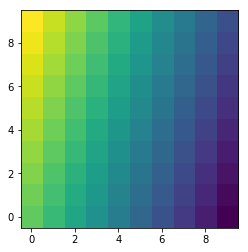

In [152]:
fig, ax = plt.subplots()
im = ax.imshow(np.array(heatmap))
ax.invert_yaxis()
plt.show()

In [127]:
def binomial(x, n, p):
    coefficient = math.factorial(n) / (math.factorial(x) * math.factorial(n - x))
    return coefficient * pow(p, x) * (1 - p, n - x)

def ev_a_new(data):
    N = data.size
    num_bad = data[data == 0].size
    num_good = data[data == 1].size
    p_prior = 1/11 * (1 - pow(10, -6))
    ev_prior = 10 * math.log(p_prior / (1 - p_prior), 10)
    
    ev_post_numerator_good = pow(2/3, num_good)
    ev_post_denominator_good = pow(5/6, num_good) + (11/10 * pow(10, -6) * pow(1/100, num_good))
    
    ev_post_numerator_bad = pow(1/3, num_bad)
    ev_post_denominator_bad = pow(1/6, num_bad) + (11/10 * pow(10, -6) * pow(99/100, num_bad))
    
    ev_posterior = 10 * (math.log(ev_post_numerator_good / ev_post_denominator_good, 10) + 
                         math.log(ev_post_numerator_bad / ev_post_denominator_bad, 10))
    return ev_prior + ev_posterior


def ev_b_new(data):
    N = data.size
    num_bad = data[data == 0].size
    num_good = data[data == 1].size
    p_prior = 10/11 * (1 - pow(10, -6))
    ev_prior = 10 * math.log(p_prior / (1 - p_prior), 10)
    
    ev_post_numerator_good = pow(5/6, num_good)
    ev_post_denominator_good = ((1 - pow(10, -6)) * pow(2/3, num_good)) + (11 * pow(10, -6) * pow(1/100, num_good))
    
    ev_post_numerator_bad = pow(1/6, num_bad)
    ev_post_denominator_bad = ((1 - pow(10, -6)) * pow(1/3, num_bad)) + (11 * pow(10, -6) * pow(99/100, num_bad))

    ev_posterior = 10 * (math.log(ev_post_numerator_good / ev_post_denominator_good, 10) + 
                         math.log(ev_post_numerator_bad / ev_post_denominator_bad, 10))
    
    return ev_prior + ev_posterior


def ev_c_new(data):
    N = data.size
    num_bad = data[data == 0].size
    num_good = data[data == 1].size
    p_prior = pow(10, -6)
    ev_prior = 10 * math.log(p_prior / (1 - p_prior), 10)
    
    ev_post_numerator_good = pow(1/100, num_good)
    ev_post_denominator_good = (1/11 * (1 - pow(10, -6)) * pow(2/3, num_good)) + (10/11 * (1 - pow(10, -6)) * pow(5/6, num_good))
    
    ev_post_numerator_bad = pow(99/100, num_bad)
    ev_post_denominator_bad = (1/11 * (1 - pow(10, -6)) * pow(1/3, num_bad)) + (10/11 * (1 - pow(10, -6)) * pow(1/6, num_bad))

    ev_data_likelihood = 10 * (math.log(ev_post_numerator_good / ev_post_denominator_good, 10) + 
                         math.log(ev_post_numerator_bad / ev_post_denominator_bad, 10))
    return ev_prior + ev_data_likelihood


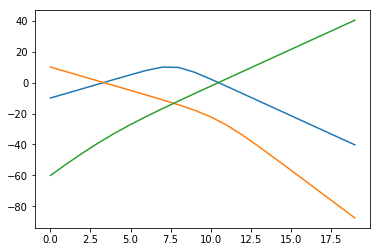

In [128]:
data = np.array([0] * 20)
evidence = np.array([ev_a_new(data[:i]) for i in range(data.size)])
plt.plot(range(data.size), evidence)

evidence = np.array([ev_b_new(data[:i]) for i in range(data.size)])
plt.plot(range(data.size), evidence)

evidence = np.array([ev_c_new(data[:i]) for i in range(data.size)])
plt.plot(range(data.size), evidence)

In [183]:
def D(H):
    if H == 0:
        return 1/3
    else:
        return 1/6

with pm.Model() as model:
    H_prior = pm.Categorical('H_prior', [1/11, 10/11])
    D_given_H = pm.Deterministic('D_given_H', pm.math.switch(np.array(H_prior == 0), 1/3, 1/6))

In [180]:
model.free_RVs

[H_prior]

In [184]:
import lea

In [231]:
hypothesis = lea.pmf({'A': 1/11, 'B': 10/11})
widget = hypothesis.switch({
    'A': lea.event(2/3),
    'B': lea.event(5/6)
})
data = (False, False, False)

In [243]:
widget_given_B = widget.given(hypothesis=='B')
widgets = lea.joint(*([widget_given_B.new() for i in range(3)]))
lea.P(widgets == data)

0.004629629629629624

In [244]:
hypothesis = lea.pmf({'A': 1/11 * (1 - pow(10, -6)), 'B': 10/11 * (1 - pow(10, -6)), 'C': pow(10, -6)})
widget = hypothesis.switch({
    'A': lea.bernoulli(2/3),
    'B': lea.bernoulli(5/6),
    'C': lea.bernoulli(1/100)
})

widget_given_B = widget.given(hypothesis=='B')

a_widgets = widget.given(hypothesis=='A').times(3)
b_widgets = widget.given(hypothesis=='B').times(3)

print(1/3 * 1/11 + 1/6 * 10/11)
widget.given(hypothesis!='C')

In [245]:
def A(x):
    return x

In [247]:
ipywidgets.interact(A, x=10)

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

<function __main__.A(x)>